## Word2Vec

### Based on https://www.tensorflow.org/tutorials/word2vec

In [0]:
import tensorflow as tf
import numpy as np
from six.moves import urllib, xrange

import collections
import math
import os 
import errno
import random
import zipfile

### The Data

In [0]:
data_dir = 'word2vec_data/words'
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [0]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [0]:
words = fetch_words_data()

In [5]:
len(words)

17005207

In [6]:
words[:20]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english']

In [7]:
for w in words[:40]:
    print (w, end = ' ')

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to 

### Buld Word Counts

In [0]:
from collections import Counter

In [0]:
my_list = ['one', 'two', 'two']

In [10]:
Counter(my_list)

Counter({'one': 1, 'two': 2})

In [11]:
Counter(my_list).most_common(), Counter(my_list).most_common(1), Counter(my_list).most_common(2)


([('two', 2), ('one', 1)], [('two', 2)], [('two', 2), ('one', 1)])

### Create Word Data and Vocal

In [0]:
def create_counts (vocal_size = 50000):
    vocab = [] + Counter(words).most_common(vocal_size)
    vocab = np.array([word for word, _ in vocab])
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data, vocab

In [0]:
vocab_size = 5000

In [0]:
data, vocabulary = create_counts(vocal_size=vocab_size)


In [15]:
data[0]

0

In [17]:
vocabulary[0]

'the'

In [18]:
vocabulary[np.random.randint(0, vocab_size)]

'singing'

### Function for Batches

Direct from word2vec file in Tensorflow Docs

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [0]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [21]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080], dtype=int32)

In [22]:
labels

array([[11],
       [ 0],
       [11],
       [ 0],
       [11],
       [ 0],
       [11],
       [ 0]], dtype=int32)

### Constants

In [0]:
batch_size = 128
embedding_size = 100
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace = False)
num_sampled = 64
learning_rate = 0.01
vocabulary_size = vocab_size

In [0]:
tf.reset_default_graph()

In [0]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variables

In [0]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1., 1)
embeddings = tf.Variable(initial_value=init_embeds)

In [0]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [0]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [29]:
loss = tf.reduce_mean(
        tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

W0617 13:54:39.978655 140598341699456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1.0)
trainer = optimizer.minimize(loss)

In [31]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis = 1, keep_dims = True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

W0617 13:54:40.346880 140598341699456 deprecation.py:506] From <ipython-input-31-08d6889468ca>:1: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Session

In [0]:
init = tf.global_variables_initializer()

In [0]:
num_steps = 10000

In [0]:
steps_ave = 100
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    loss_list = []
    for step in range(1, num_steps+1):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        empty, loss_val = sess.run([trainer, loss], feed_dict = feed_dict)
        average_loss += loss_val
        
        if step % steps_ave == 0:
            loss_list.append(average_loss/steps_ave)
            average_loss =0 
    final_embeddings = normalized_embeddings.eval()

In [0]:
import matplotlib.pyplot as plt

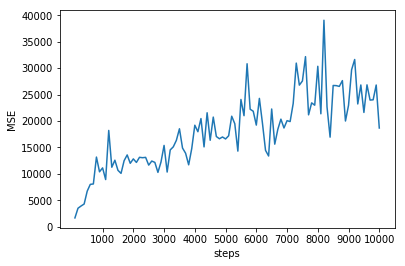

In [39]:
#plt.plot(loss_list)
plt.plot(range(steps_ave, steps_ave*(0+len(loss_list))+1, steps_ave), loss_list)
plt.xlabel('steps')
plt.ylabel('MSE')
plt.xticks(list(range(10*steps_ave, steps_ave*(0+len(loss_list))+1, 10*steps_ave)), labels = [str(i) for i in range(10*steps_ave, steps_ave*(0+len(loss_list))+1, 10*steps_ave)])
plt.show()

### Visualizing Results

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(19, 19))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [77]:
type(final_embeddings)

numpy.ndarray

In [78]:
final_embeddings.shape

(5000, 100)

In [0]:
from sklearn.manifold import TSNE

In [0]:
tsne = TSNE (perplexity = 30, n_components = 2, init='pca', n_iter=5000)

In [0]:
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

In [0]:
labels = [vocabulary[i] for i in range(plot_only)]

In [87]:
low_dim_embs.shape

(500, 2)

(-10, 10)

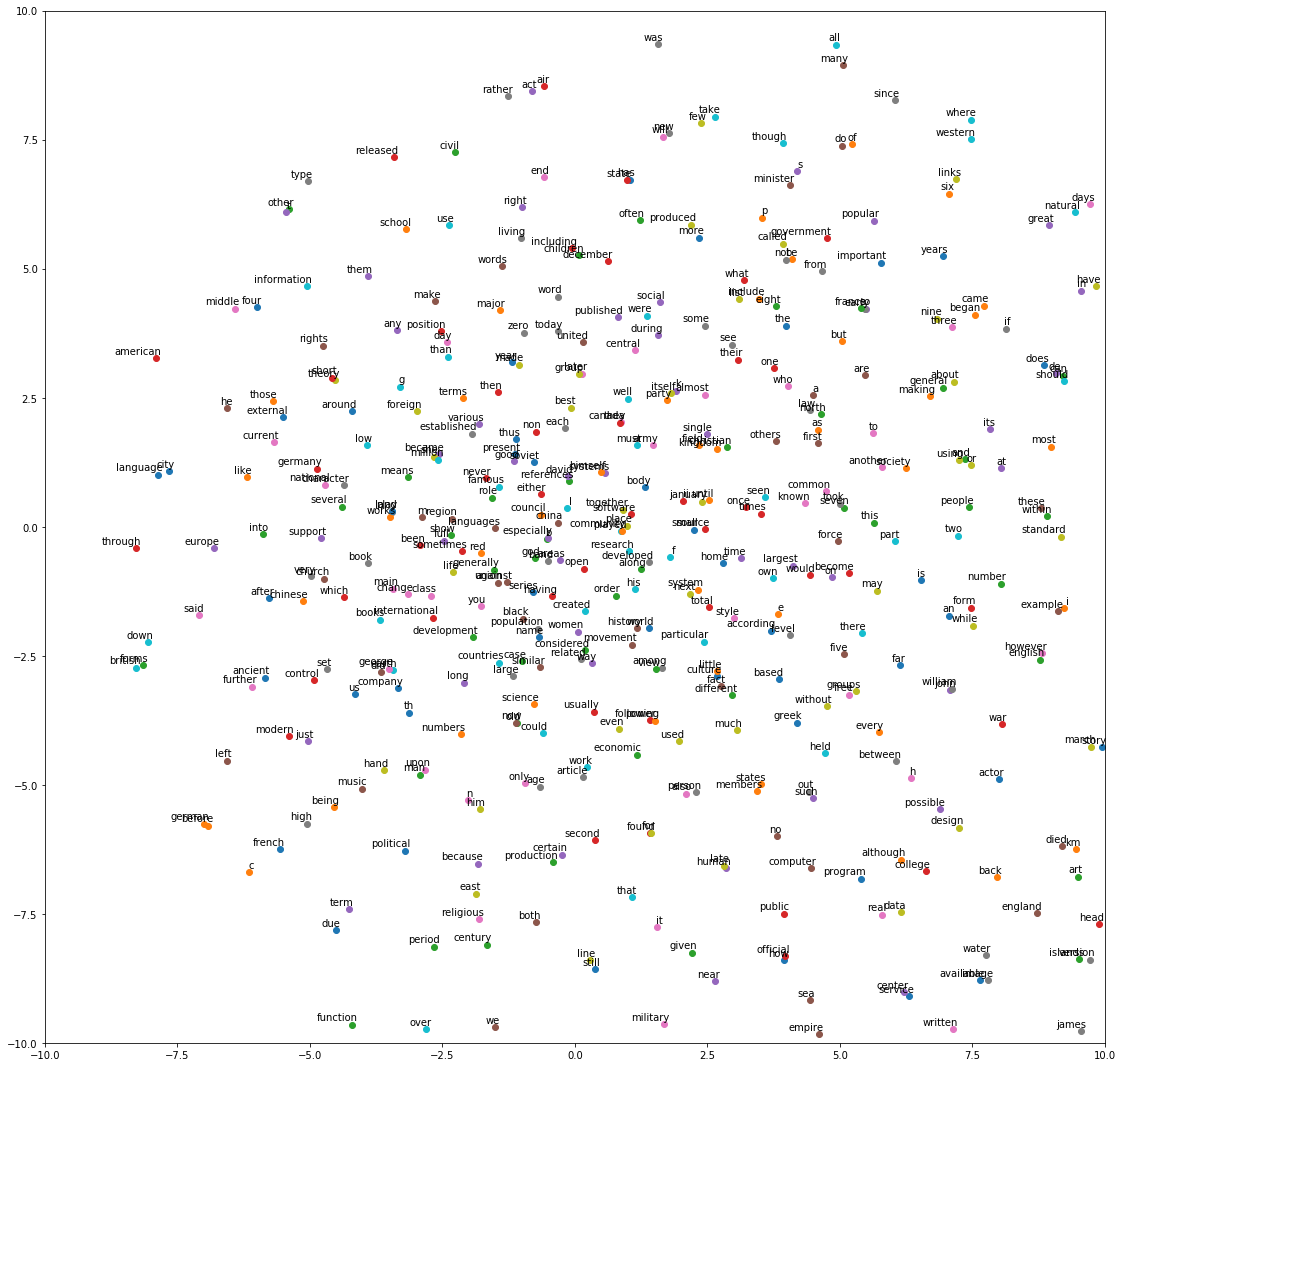

In [89]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10, 10)
plt.ylim(-10, 10)